In [37]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from plotnine import ggplot, aes, geom_point, labs, theme_minimal, theme, element_text, coord_cartesian

import warnings
warnings.filterwarnings('ignore')


First, we’ll read and clean our data..



In [7]:
# Read the data
ames = pd.read_csv("/content/AmesHousing.csv")

# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

# OLS Model

In [8]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

lr_model = lr_pipeline_1.fit(X,y)


# Get the coefficients of the linear regression model
coefs_linear = lr_pipeline_1.named_steps["linear_regression"].coef_
len(coefs_linear)

259

In [9]:
cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'r2')

array([-4.59217770e+20, -1.21723181e+20, -8.37868327e+19, -9.71584476e+20,
       -3.78389822e+20])

# Ridge Regression Model


Practice Activity: Make a pipeline that uses all the variables in the Ames dataset, and then fits Ridge Regression with lambda = 1.

Cross-validate this pipeline and compare the results to the ordinary linear regression.

Then fit the model on the whole dataset and get the coefficients. Make a plot of these coefficients compared to the ones from ordinary linear regression.

In [10]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]

ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

ridge_pipeline = Pipeline([('preprocessor', ct),('regressor', Ridge())])

ridge_pipeline.fit(X, y)

# Get the coefficients of the ridge regression model
coefs_ridge = ridge_pipeline.named_steps["regressor"].coef_
len(coefs_ridge)

259

In [11]:
coefficients_df = pd.DataFrame(data = {"Linear": coefs_linear, "Ridge": coefs_ridge})
coefficients_df

,Linear,Ridge
0,-6.831270e+13,-5740.055372
1,-6.831270e+13,1511.928887
2,-6.831270e+13,-5809.704488
3,-6.831270e+13,7676.327583
4,-6.831270e+13,3215.393618
...,...,...
254,2.708000e+03,2937.762099
255,2.714000e+03,1377.194605
256,-5.204000e+03,-4485.971545
257,-6.960000e+02,-674.189275


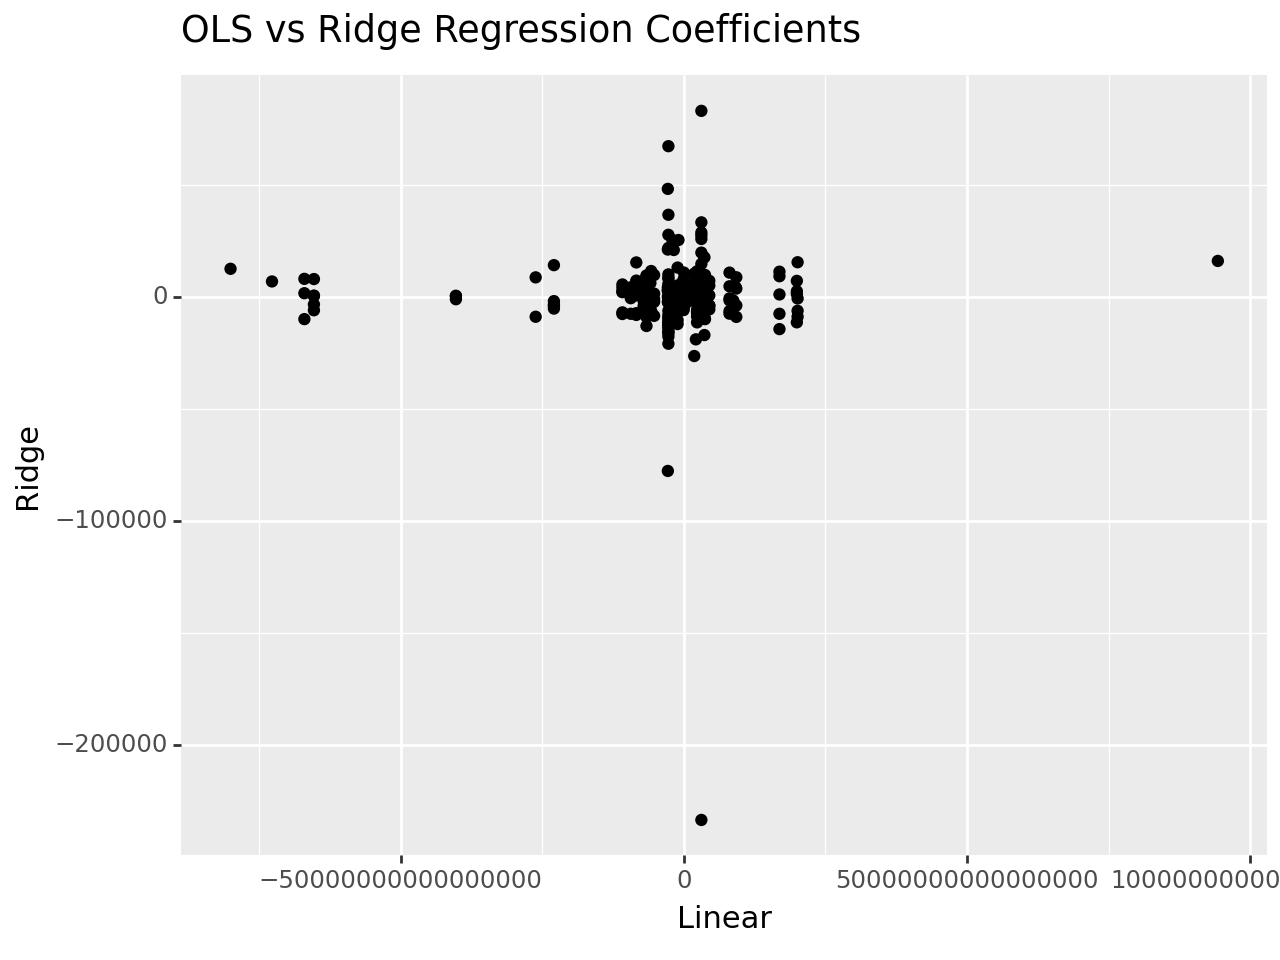

<Figure Size: (640 x 480)>

In [12]:
plot = (ggplot(coefficients_df, aes(x="Linear", y="Ridge"))
  + geom_point()
  + labs (title = 'OLS vs Ridge Regression Coefficients'))

plot

# Practice Activity:

Using the same pipeline as previously, perform tuning on lambda.

You should always try lambda values on a log scale; that is, don’t use [1,2,3,4]; instead use something like [0.001, 0.01, 0.1, 1, 10]

In [13]:
# fit the model on the whole dataset and get the coefficients

ridge_pipeline.fit(X, y)

cross_val_score_ridge = cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = 'r2')

cross_val_score_linear = cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'r2')

In [14]:
alpha_values = [0.001, 0.01, 0.1, 1, 10]

alpha_grid = {'regressor__alpha': alpha_values}

gscv = GridSearchCV(ridge_pipeline, alpha_grid, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)

gscv_fitted.cv_results_

{'mean_fit_time': array([0.06596079, 0.06684675, 0.07490983, 0.07243896, 0.05694079]),
 'std_fit_time': array([0.01774639, 0.01870117, 0.0183695 , 0.01220387, 0.01639296]),
 'mean_score_time': array([0.02175598, 0.02164054, 0.02084765, 0.02556171, 0.01844597]),
 'std_score_time': array([0.00789516, 0.00518684, 0.00693198, 0.00771919, 0.0061898 ]),
 'param_regressor__alpha': masked_array(data=[0.001, 0.01, 0.1, 1, 10],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'regressor__alpha': 0.001},
  {'regressor__alpha': 0.01},
  {'regressor__alpha': 0.1},
  {'regressor__alpha': 1},
  {'regressor__alpha': 10}],
 'split0_test_score': array([0.89854203, 0.89857655, 0.89877654, 0.8983804 , 0.89725065]),
 'split1_test_score': array([0.90960213, 0.90983697, 0.91174047, 0.91749817, 0.92136221]),
 'split2_test_score': array([0.78694665, 0.78705498, 0.78801513, 0.79251623, 0.79751148]),
 'split3_test_score': array([0.76870417, 

In [15]:
results = gscv_fitted.cv_results_['mean_test_score']

In [16]:
pd.DataFrame(data = {"alpha": [0.001, 0.01, 0.1, 1, 10], "scores": results})

,alpha,scores
0,0.001,0.852945
1,0.010,0.853224
2,0.100,0.855423
3,1.000,0.861159
4,10.000,0.863355


Chosen ridge model:

In [17]:
ridge_pipeline2 = Pipeline([('preprocessor', ct),
                          ('regressor', Ridge(alpha=10))])

model_ridge2 = ridge_pipeline2.fit(X, y)

# Get the coefficients of the chosen ridge regression model
coefs_ridge2 = ridge_pipeline2.named_steps["regressor"].coef_

coefs_ridge2

array([-4.85094592e+03,  2.06638926e+03, -1.25886291e+03,  4.44722578e+03,
        2.34871909e+03, -2.75252531e+03, -5.83247363e+03,  5.83247363e+03,
        2.31233042e+03,  7.32962737e+03, -1.24531787e+04,  2.81122089e+03,
       -1.11224443e+04,  8.88328411e+03, -1.26747050e+03,  3.50663067e+03,
        3.01750926e+03, -2.59848635e+03, -4.19022913e+02, -8.41260699e+01,
        7.59338485e+03, -5.73685935e+03, -2.31625871e+03,  5.43859276e+02,
       -8.82362352e+01,  5.66136141e+03, -5.57312518e+03, -1.82924573e+03,
        1.87016999e+03,  5.99520029e+03, -7.67705746e+02, -4.10486548e+03,
       -8.32881350e+03,  9.09552956e+03, -1.56963025e+04, -1.13576156e+04,
        1.15711997e+03,  1.25635693e+04, -6.68088456e+03, -4.62573873e+02,
        1.24778131e+03, -1.03711746e+04, -1.06702684e+04,  3.52269485e+03,
       -1.25655836e+04,  2.72650861e+04,  2.17555850e+04, -9.90799673e+03,
       -7.00430668e+03, -6.27472964e+03, -8.75404865e+03,  8.99835289e+03,
        3.04140260e+04, -

Practice Activity:
Create a LASSO pipeline, and tune lambda.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS

# LASSO Regression Model

In [18]:
lasso_pipeline = Pipeline([('preprocessor', ct),
                          ('regressor', Lasso())])

gscv = GridSearchCV(lasso_pipeline, alpha_grid, cv = 5, scoring='r2')

gscv

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('dummify',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7bc6baddd840>),
                                                                        ('standardize',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7bc6baddd480>)])),
                                       ('regressor', Lasso())]),
             param_grid={'regressor__alpha': [0.001, 0.01, 0.1, 1, 10]},
             scoring='r2')

In [19]:
model_lasso = lasso_pipeline.fit(X, y)

lasso_fitted = gscv.fit(X, y)

results = lasso_fitted.cv_results_['mean_test_score']
results

array([0.8544398 , 0.85454916, 0.85539429, 0.85589007, 0.85949508])

In [20]:
pd.DataFrame(data = {"alpha": [0.001, 0.01, 0.1, 1, 10], "scores": results})

,alpha,scores
0,0.001,0.854440
1,0.010,0.854549
2,0.100,0.855394
3,1.000,0.855890
4,10.000,0.859495


In [21]:
# Get the coefficients of the lasso regression model
coefs_lasso = model_lasso.named_steps["regressor"].coef_
len(coefs_lasso)

259

Chosen lasso model:

In [22]:
lasso_pipeline2 = Pipeline([('preprocessor', ct),
                          ('regressor', Lasso(alpha=10))])

model_lasso2 = lasso_pipeline2.fit(X, y)

# Get the coefficients of the chosen lasso regression model
coefs_lasso2 = model_lasso2.named_steps["regressor"].coef_
coefs_lasso2

array([-4.98858303e+03,  0.00000000e+00, -0.00000000e+00,  4.00181341e+03,
        2.14948506e+03, -2.11477605e+03, -1.59450790e+04,  6.35818301e-10,
       -1.20191692e+03,  4.04633342e+03, -0.00000000e+00,  0.00000000e+00,
       -9.66549017e+03,  5.20215419e+03, -9.22804541e+03,  1.84785086e+02,
        4.47757943e+03, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        6.58680683e+03, -5.90434708e+03, -1.94634911e+03,  0.00000000e+00,
       -0.00000000e+00,  5.84192249e+03, -1.23322174e+04,  7.48644321e+03,
        7.91253765e+03,  1.34266297e+04,  3.24998752e+03, -0.00000000e+00,
       -2.60026242e+03,  1.43138097e+04, -1.07407923e+04, -4.02688778e+03,
        9.19393978e+03,  1.10738947e+05, -3.03284734e+03,  0.00000000e+00,
        6.62601594e+03, -6.46633247e+03, -6.33874747e+03,  1.39178351e+04,
       -8.86182281e+03,  3.47073682e+04,  2.72683598e+04, -6.92148410e+03,
       -4.03337169e+03, -1.80762219e+03, -3.25196177e+03,  1.78266699e+04,
        4.41965192e+04, -

# Practice Activity:

Create an Elastic Net pipeline, and tune lambda and alpha.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS.

# Elastic Net Model

In [23]:
elasticnet_pipeline = Pipeline(steps=[('preprocessor', ct),
                                      ('regressor', ElasticNet())])

# l1_ratio values
l1_ratio_values = [0.2, 0.4, 0.6, 0.8, 1]

# Set up the grid search with Elastic Net within a pipeline
param_grid = {
    'regressor__alpha': alpha_values,
    'regressor__l1_ratio': l1_ratio_values}

elasticnet_gscv = GridSearchCV(elasticnet_pipeline, param_grid, cv=5, scoring='r2')

model_elasticnet = elasticnet_pipeline.fit(X, y)

elasticnet_fitted = elasticnet_gscv.fit(X, y)

results = elasticnet_fitted.cv_results_['mean_test_score']

In [24]:
alphas = elasticnet_fitted.cv_results_['param_regressor__alpha']
lambdas = elasticnet_fitted.cv_results_['param_regressor__l1_ratio']

In [25]:
pd.DataFrame(data = {"alpha": alphas,"l1_ratio": lambdas, "scores": results}).sort_values(by="scores", ascending = False)

,alpha,l1_ratio,scores
7,0.01,0.6,0.863350
6,0.01,0.4,0.863279
5,0.01,0.2,0.863049
8,0.01,0.8,0.863035
0,0.001,0.2,0.862113
1,0.001,0.4,0.861691
2,0.001,0.6,0.860950
13,0.1,0.8,0.860939
24,10,1,0.859495
3,0.001,0.8,0.859277


**The best model using ElasticNet has an alpha of 0.01 and lambda of 0.6.**





Chosen Elastic Net Model:

In [26]:
elasticnet_pipeline2 = Pipeline(steps=[('preprocessor', ct),
                                      ('regressor', ElasticNet(alpha=0.01, l1_ratio=0.6))])

model_elasticnet2 = elasticnet_pipeline2.fit(X, y)

# Get the coefficients of the lasso regression model
coefs_elasticnet2 = model_lasso2.named_steps["regressor"].coef_
coefs_elasticnet2

array([-4.98858303e+03,  0.00000000e+00, -0.00000000e+00,  4.00181341e+03,
        2.14948506e+03, -2.11477605e+03, -1.59450790e+04,  6.35818301e-10,
       -1.20191692e+03,  4.04633342e+03, -0.00000000e+00,  0.00000000e+00,
       -9.66549017e+03,  5.20215419e+03, -9.22804541e+03,  1.84785086e+02,
        4.47757943e+03, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        6.58680683e+03, -5.90434708e+03, -1.94634911e+03,  0.00000000e+00,
       -0.00000000e+00,  5.84192249e+03, -1.23322174e+04,  7.48644321e+03,
        7.91253765e+03,  1.34266297e+04,  3.24998752e+03, -0.00000000e+00,
       -2.60026242e+03,  1.43138097e+04, -1.07407923e+04, -4.02688778e+03,
        9.19393978e+03,  1.10738947e+05, -3.03284734e+03,  0.00000000e+00,
        6.62601594e+03, -6.46633247e+03, -6.33874747e+03,  1.39178351e+04,
       -8.86182281e+03,  3.47073682e+04,  2.72683598e+04, -6.92148410e+03,
       -4.03337169e+03, -1.80762219e+03, -3.25196177e+03,  1.78266699e+04,
        4.41965192e+04, -

In [38]:
# Get the coefficients of the elastic net model
coefs_model_elasticnet = model_elasticnet.named_steps["regressor"].coef_
len(coefs_model_elasticnet)

259

## Comparing the Coefficients Of Elastic Net, Ridge and OLS Regression Models

In [28]:
coefficients_df = pd.DataFrame(data = {"Flexibility": np.arange(0,259), "Ridge": coefs_ridge2, "Lasso": coefs_lasso2, "Elastic Net": coefs_model_elasticnet })
coefficients_df

,Flexibility,Ridge,Lasso,Elastic Net
0,0,-4850.945920,-4988.583032,-142.792827
1,1,2066.389264,0.000000,342.019719
2,2,-1258.862909,-0.000000,-20.383127
3,3,4447.225780,4001.813415,-55.146816
4,4,2348.719094,2149.485061,1208.813230
...,...,...,...,...
254,254,3130.514090,2625.911822,2609.782092
255,255,465.334450,2548.565968,98.626994
256,256,-4188.491022,-4917.685328,-3165.608500
257,257,-606.042386,-707.921096,-76.714905


In [29]:
# Create a scaler object
scaler = StandardScaler()

# Reshape is used as scaler requires a 2D array input
scaler.fit(coefficients_df[['Ridge', 'Lasso', 'Elastic Net']])

# Transform the data and replace the columns in the dataframe
coefficients_df[['Ridge', 'Lasso', 'Elastic Net']] = scaler.transform(coefficients_df[['Ridge', 'Lasso', 'Elastic Net']])

coefficients_df


,Flexibility,Ridge,Lasso,Elastic Net
0,0,-0.766191,-0.127798,-0.273500
1,1,0.258940,0.004356,0.000746
2,2,-0.233854,0.004356,-0.204256
3,3,0.611773,0.110369,-0.223921
4,4,0.300780,0.061299,0.491070
...,...,...,...,...
254,254,0.416640,0.073920,1.283565
255,255,0.021668,0.071871,-0.136935
256,256,-0.668017,-0.125920,-1.983434
257,257,-0.137107,-0.014398,-0.236122


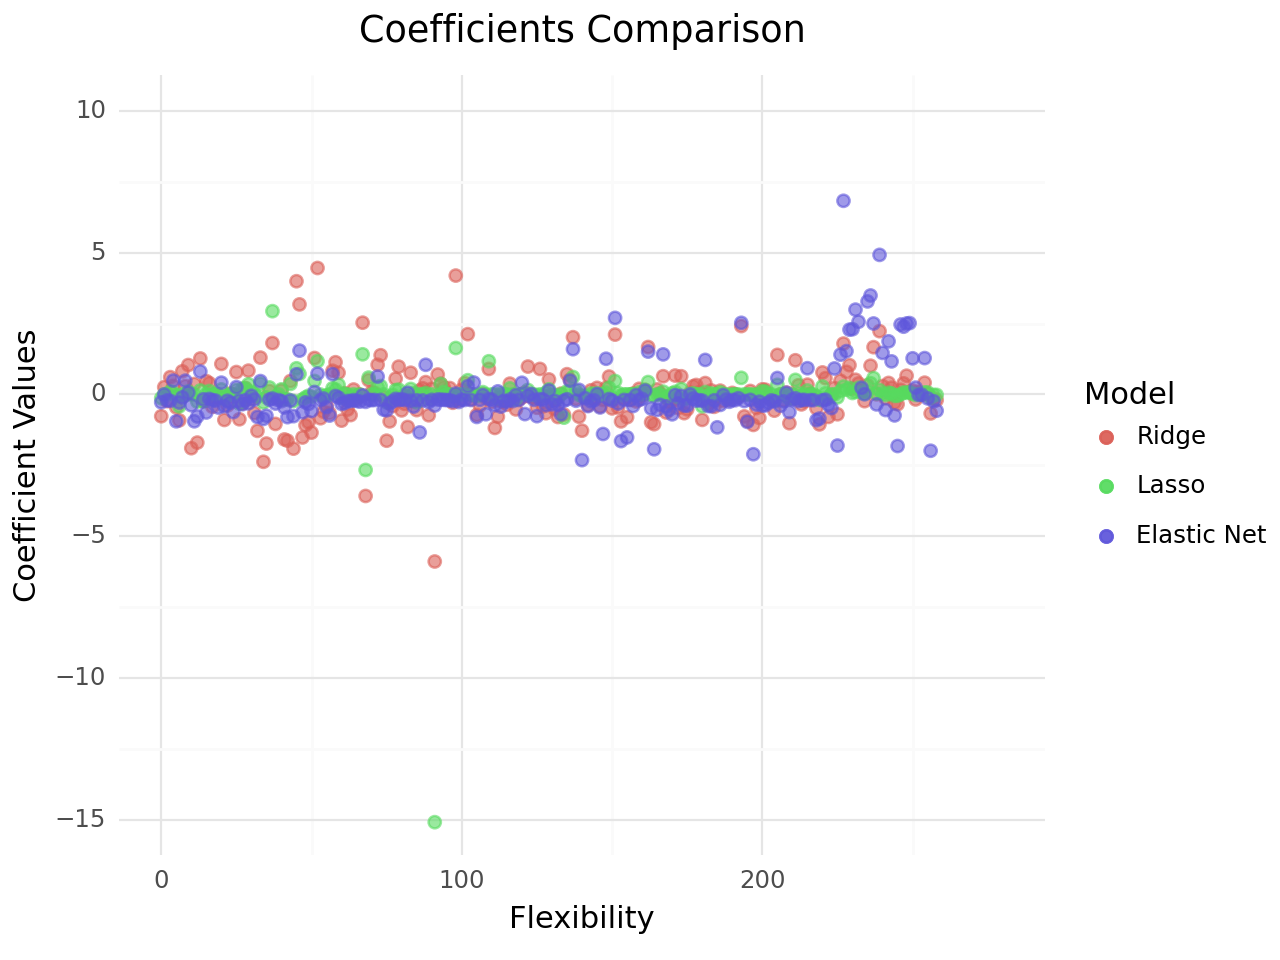

In [39]:
plot = (ggplot(coefficients_df) +
        geom_point(aes(x='Flexibility', y='Ridge', color='"Ridge"'), size=2, alpha=0.6) +
        geom_point(aes(x='Flexibility', y='Lasso', color='"Lasso"'), size=2, alpha=0.6) +
        geom_point(aes(x='Flexibility', y='Elastic Net', color='"Elastic Net"'), size=2, alpha=0.6) +
        labs(x='Flexibility', y='Coefficient Values', title='Coefficients Comparison') +
        theme_minimal() +
        theme(plot_title=element_text(hjust=0.5),  # Center the title
              legend_title=element_text(text='Model'),  # Add legend title
              legend_position='right') +  # Position the legend
        coord_cartesian(ylim=(-15, 10), xlim=(0, 280))  # Zoom into the area with ylim and xlim
        )

# Show the plot
print(plot)
